# MADE: Masked Autoencoder for Distribution Estimation on MNIST

This notebook implements the MADE architecture from the paper:
**"MADE: Masked Autoencoder for Distribution Estimation"** by Germain et al. (2015)

MADE is an autoregressive generative model that uses masked weight matrices to ensure the autoregressive property, allowing efficient density estimation and sampling.

## 1. Import Required Libraries

In [126]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 2. Load and Preprocess MNIST Dataset

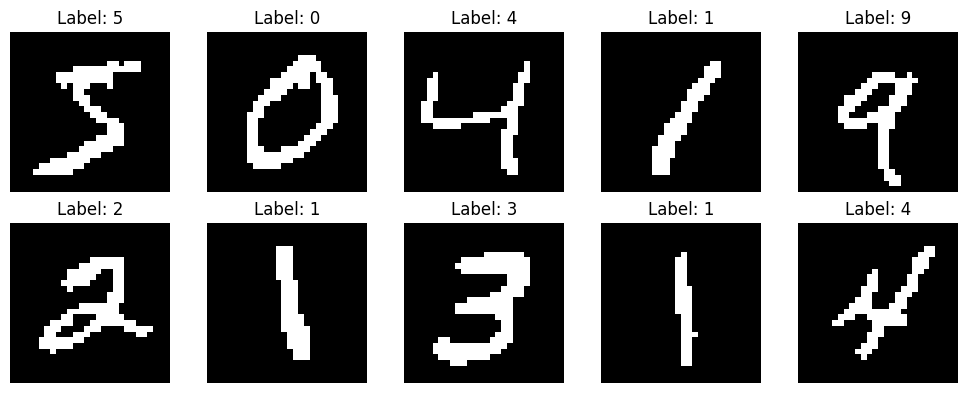

Training samples: 60000
Test samples: 10000
Input dimension: 784 (flattened)


In [127]:
# Transform to binarize MNIST (convert to 0s and 1s)
# We'll threshold at 0.5 after normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float())  # Binarize
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Visualize some samples
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

print(f'Training samples: {len(train_dataset)}')
print(f'Test samples: {len(test_dataset)}')
print(f'Input dimension: {28 * 28} (flattened)')

## 3. Implement Masked Linear Layer

The core of MADE is the `MaskedLinear` layer, which applies element-wise masks to weight matrices to ensure the autoregressive property.

In [128]:
class MaskedLinear(nn.Linear):
    """
    Linear layer with a configurable mask on the weights.
    The mask ensures that connections respect the autoregressive property.
    """
    def __init__(self, in_features, out_features, bias=True):
        super().__init__(in_features, out_features, bias)
        self.register_buffer('mask', torch.ones(out_features, in_features))

    def set_mask(self, mask):
        """Set the mask for this layer."""
        self.mask.data.copy_(torch.from_numpy(mask.astype(np.float32)))

    def forward(self, x):
        """Forward pass with masked weights."""
        return F.linear(x, self.weight * self.mask, self.bias)

## 4. Implement the MADE Model

The MADE model creates masks that enforce the autoregressive property:
- Each output dimension depends only on previous input dimensions
- Hidden units are assigned "degrees" that determine connectivity

In [129]:
class MADE(nn.Module):
    """
    Masked Autoencoder for Distribution Estimation.

    Args:
        input_dim: Dimension of input (784 for MNIST)
        hidden_dims: List of hidden layer dimensions
        natural_ordering: If True, use natural ordering (1,2,3,...), else random
    """
    def __init__(self, input_dim, hidden_dims, natural_ordering=True):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.natural_ordering = natural_ordering

        # Build network layers
        self.layers = nn.ModuleList()
        dims = [input_dim] + hidden_dims + [input_dim]

        for i in range(len(dims) - 1):
            self.layers.append(MaskedLinear(dims[i], dims[i+1]))

        # Create masks
        self.create_masks()

    def create_masks(self):
        """
        Create masks for all layers to enforce autoregressive property.

        The key idea:
        - Assign each input dimension a number from 1 to D
        - Assign each hidden unit a number from 1 to D-1
        - A hidden unit with degree k can only connect to inputs with degree <= k
        - Output i can only connect to hidden units with degree < i
        """
        L = len(self.hidden_dims)

        # Assign degrees to each layer
        # m[l] contains the degrees for layer l
        self.m = {}

        # Input layer: degrees are 1, 2, ..., D (natural ordering) or permutation
        if self.natural_ordering:
            self.m[0] = np.arange(1, self.input_dim + 1)
        else:
            self.m[0] = np.random.permutation(np.arange(1, self.input_dim + 1))

        # Hidden layers: degrees are randomly sampled from 1 to D-1
        for l in range(1, L + 1):
            # Sample degrees between min(m[l-1]) and D-1
            self.m[l] = np.random.randint(
                self.m[l-1].min(),
                self.input_dim,
                size=self.hidden_dims[l-1]
            )

        # Output layer: same as input
        self.m[L + 1] = self.m[0]

        # Create masks based on degrees
        masks = []
        for l in range(len(self.layers)):
            if l < len(self.layers) - 1:
                # Hidden layer mask: m[l+1][i] >= m[l][j]
                mask = (self.m[l + 1][:, None] >= self.m[l][None, :]).astype(np.float32)
            else:
                # Output layer mask: m[l+1][i] > m[l][j] (strict inequality)
                mask = (self.m[l + 1][:, None] > self.m[l][None, :]).astype(np.float32)

            masks.append(mask)
            self.layers[l].set_mask(mask)

    def forward(self, x):
        """
        Forward pass through the network.
        Returns logits for Bernoulli distributions over each dimension.
        """
        # Flatten input if needed
        if len(x.shape) > 2:
            x = x.view(x.size(0), -1)

        # Pass through layers with ReLU activations (except last layer)
        for i, layer in enumerate(self.layers[:-1]):
            x = F.relu(layer(x))

        # Last layer without activation (outputs logits)
        x = self.layers[-1](x)

        return x

    def sample(self, n_samples):
        """
        Generate samples using ancestral sampling.
        Sample each dimension sequentially conditioned on previous dimensions.
        """
        samples = torch.zeros(n_samples, self.input_dim).to(device)

        with torch.no_grad():
            for i in range(self.input_dim):
                # Forward pass to get probabilities
                logits = self.forward(samples)
                probs = torch.sigmoid(logits)

                # Sample dimension i
                samples[:, i] = torch.bernoulli(probs[:, i])

        return samples

## 5. Initialize the Model

In [130]:
# Model hyperparameters
input_dim = 28 * 28  # 784 for MNIST
hidden_dims = [4000]  # Two hidden layers with 500 units each

# Create model
model = MADE(input_dim, hidden_dims, natural_ordering=True).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total parameters: {total_params:,}')
print(f'\nModel architecture:')
print(model)

Total parameters: 6,276,784

Model architecture:
MADE(
  (layers): ModuleList(
    (0): MaskedLinear(in_features=784, out_features=4000, bias=True)
    (1): MaskedLinear(in_features=4000, out_features=784, bias=True)
  )
)


## 6. Define Loss Function and Optimizer

For binary MNIST, we use binary cross-entropy loss (negative log-likelihood of Bernoulli distributions).

In [131]:
def loss_function(logits, targets):
    """
    Compute negative log-likelihood for binary data.

    Args:
        logits: Model output (batch_size, input_dim)
        targets: Binary target data (batch_size, input_dim)

    Returns:
        Average negative log-likelihood per sample
    """
    # Binary cross entropy from logits
    loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
    # Sum over dimensions, average over batch
    return loss.sum(dim=1).mean()

# Optimizer
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print(f'Optimizer: Adam with learning rate {learning_rate}')

Optimizer: Adam with learning rate 0.001


## 7. Training Loop

In [132]:
def train_epoch(model, train_loader, optimizer):
    """Train for one epoch."""
    model.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(data.size(0), -1).to(device)

        optimizer.zero_grad()
        logits = model(data)
        loss = loss_function(logits, data)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(train_loader)

def evaluate(model, test_loader):
    """Evaluate on test set."""
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(data.size(0), -1).to(device)
            logits = model(data)
            loss = loss_function(logits, data)
            test_loss += loss.item()

    return test_loss / len(test_loader)

# Training
num_epochs = 40
train_losses = []
test_losses = []

print('Starting training...\n')

for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch(model, train_loader, optimizer)
    test_loss = evaluate(model, test_loader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'Epoch {epoch:2d}/{num_epochs} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}')

print('\nTraining complete!')

Starting training...

Epoch  1/40 | Train Loss: 148.6618 | Test Loss: 97.5995
Epoch  2/40 | Train Loss: 89.8827 | Test Loss: 82.6286
Epoch  3/40 | Train Loss: 79.3501 | Test Loss: 76.1371
Epoch  4/40 | Train Loss: 73.8376 | Test Loss: 72.7324
Epoch  5/40 | Train Loss: 70.4607 | Test Loss: 70.5366
Epoch  6/40 | Train Loss: 68.1620 | Test Loss: 69.1821
Epoch  7/40 | Train Loss: 66.4589 | Test Loss: 68.3685
Epoch  8/40 | Train Loss: 65.1562 | Test Loss: 67.7659
Epoch  9/40 | Train Loss: 64.0808 | Test Loss: 67.3977
Epoch 10/40 | Train Loss: 63.1608 | Test Loss: 67.1760
Epoch 11/40 | Train Loss: 62.3663 | Test Loss: 66.8857
Epoch 12/40 | Train Loss: 61.6689 | Test Loss: 66.5848
Epoch 13/40 | Train Loss: 61.0202 | Test Loss: 66.5883
Epoch 14/40 | Train Loss: 60.4186 | Test Loss: 66.6188
Epoch 15/40 | Train Loss: 59.9128 | Test Loss: 66.6212
Epoch 16/40 | Train Loss: 59.4046 | Test Loss: 66.6677
Epoch 17/40 | Train Loss: 58.9526 | Test Loss: 66.7533
Epoch 18/40 | Train Loss: 58.4951 | Test L

## 8. Visualize Training Progress

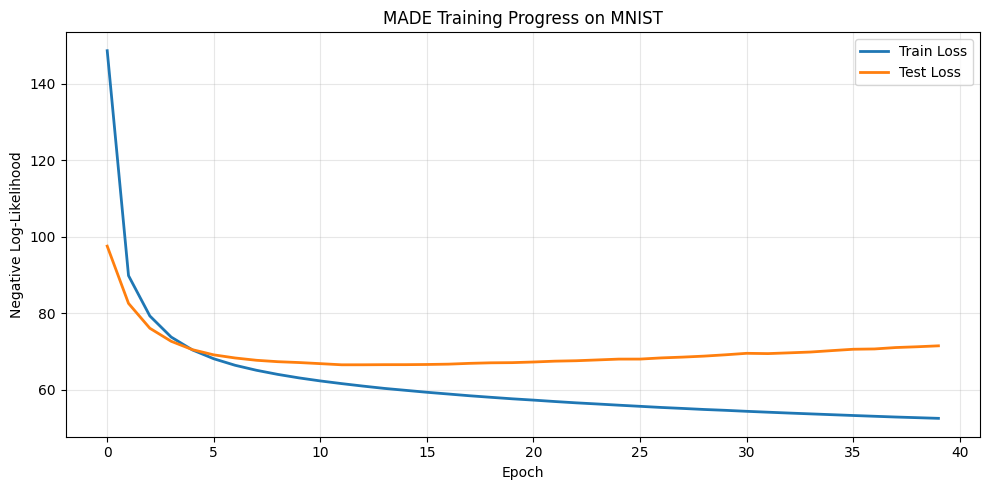

Final Train Loss: 52.5931
Final Test Loss: 71.5420


In [133]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(test_losses, label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood')
plt.title('MADE Training Progress on MNIST')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Final Train Loss: {train_losses[-1]:.4f}')
print(f'Final Test Loss: {test_losses[-1]:.4f}')

## 9. Generate Samples Using Ancestral Sampling

MADE can generate new samples by sequentially sampling each pixel conditioned on previously sampled pixels.

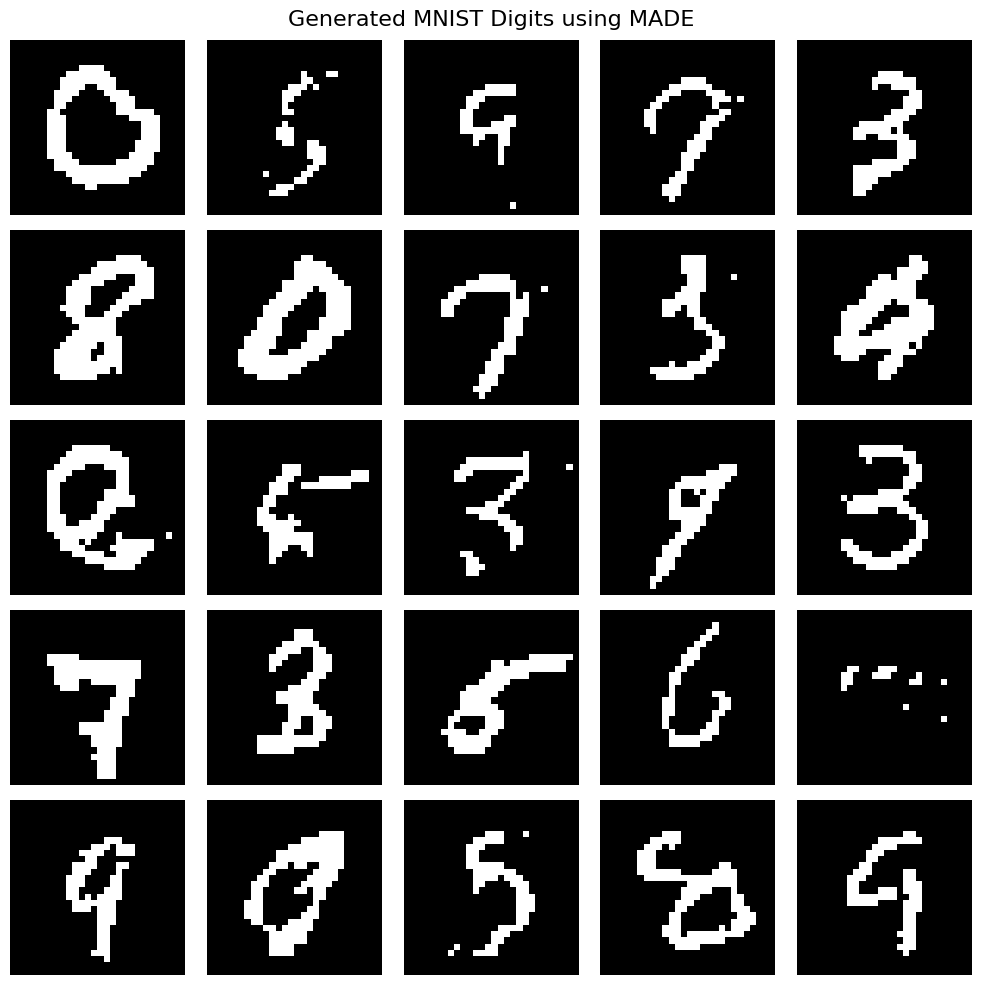

In [134]:
# Generate samples
model.eval()
n_samples = 25
samples = model.sample(n_samples)

# Reshape and visualize
samples = samples.cpu().numpy().reshape(-1, 28, 28)

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i], cmap='gray')
    ax.axis('off')
plt.suptitle('Generated MNIST Digits using MADE', fontsize=16)
plt.tight_layout()
plt.show()

## 10. Evaluate Model - Log-Likelihood per Dimension

Calculate the average bits per dimension on the test set (a common metric for generative models).

In [135]:
# Calculate bits per dimension
model.eval()
total_nll = 0
total_samples = 0

with torch.no_grad():
    for data, _ in test_loader:
        data = data.view(data.size(0), -1).to(device)
        logits = model(data)

        # Binary cross entropy per pixel
        nll = F.binary_cross_entropy_with_logits(logits, data, reduction='sum')
        total_nll += nll.item()
        total_samples += data.size(0)

avg_nll_per_sample = total_nll / total_samples
avg_nll_per_dim = avg_nll_per_sample / input_dim
bits_per_dim = avg_nll_per_dim / np.log(2)  # Convert from nats to bits

print(f'Test Set Evaluation:')
print(f'  Average NLL per sample: {avg_nll_per_sample:.4f} nats')
print(f'  Average NLL per dimension: {avg_nll_per_dim:.4f} nats')
print(f'  Bits per dimension: {bits_per_dim:.4f} bits')
print(f'\nNote: Lower values indicate better density estimation.')

Test Set Evaluation:
  Average NLL per sample: 71.6352 nats
  Average NLL per dimension: 0.0914 nats
  Bits per dimension: 0.1318 bits

Note: Lower values indicate better density estimation.


## 11. Visualize Learned Conditional Distributions

We can visualize what the model has learned by fixing all but one pixel and showing the predicted probability for that pixel.

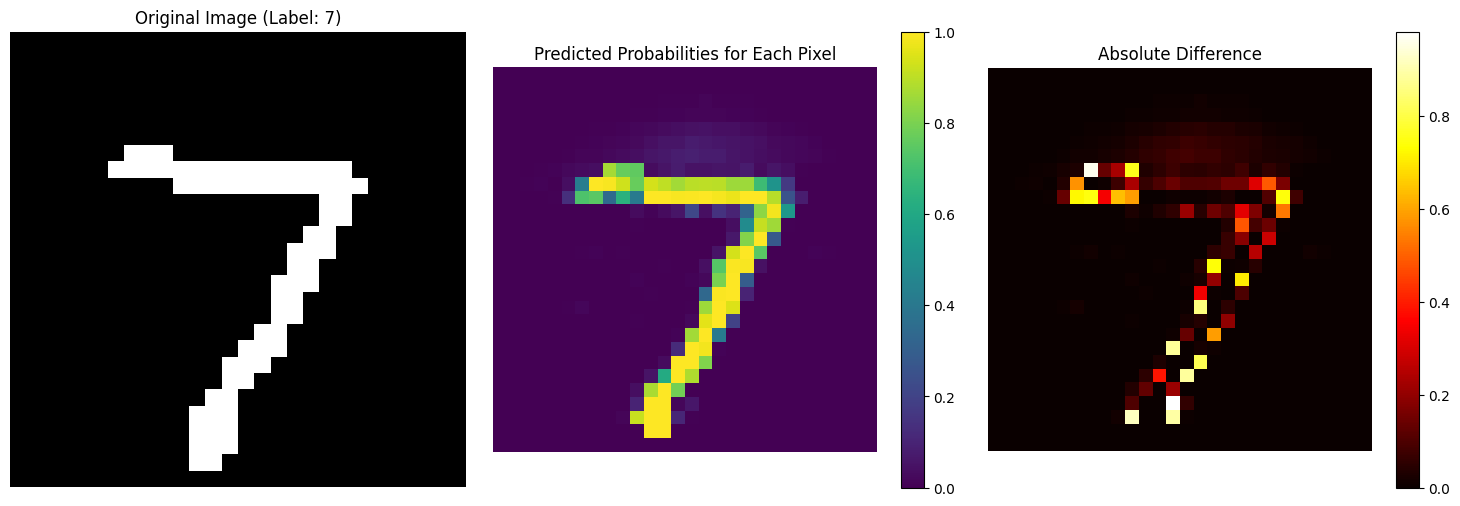

Average predicted probability on active pixels: 0.8364
Average predicted probability on inactive pixels: 0.0200


In [136]:
# Take a test image and visualize conditional probabilities
model.eval()
test_img, test_label = test_dataset[0]
test_img_flat = test_img.view(1, -1).to(device)

with torch.no_grad():
    logits = model(test_img_flat)
    probs = torch.sigmoid(logits)

# Reshape
probs_img = probs.cpu().numpy().reshape(28, 28)
test_img_show = test_img.squeeze().cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original image
axes[0].imshow(test_img_show, cmap='gray')
axes[0].set_title(f'Original Image (Label: {test_label})')
axes[0].axis('off')

# Predicted probabilities
im = axes[1].imshow(probs_img, cmap='viridis', vmin=0, vmax=1)
axes[1].set_title('Predicted Probabilities for Each Pixel')
axes[1].axis('off')
plt.colorbar(im, ax=axes[1])

# Difference
diff = np.abs(test_img_show - probs_img)
im2 = axes[2].imshow(diff, cmap='hot')
axes[2].set_title('Absolute Difference')
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2])

plt.tight_layout()
plt.show()

print(f'Average predicted probability on active pixels: {probs_img[test_img_show == 1].mean():.4f}')
print(f'Average predicted probability on inactive pixels: {probs_img[test_img_show == 0].mean():.4f}')

## 12. Visualize Reconstruction Quality

Compare original test images with the model's predicted probabilities to see how well it captures the data.

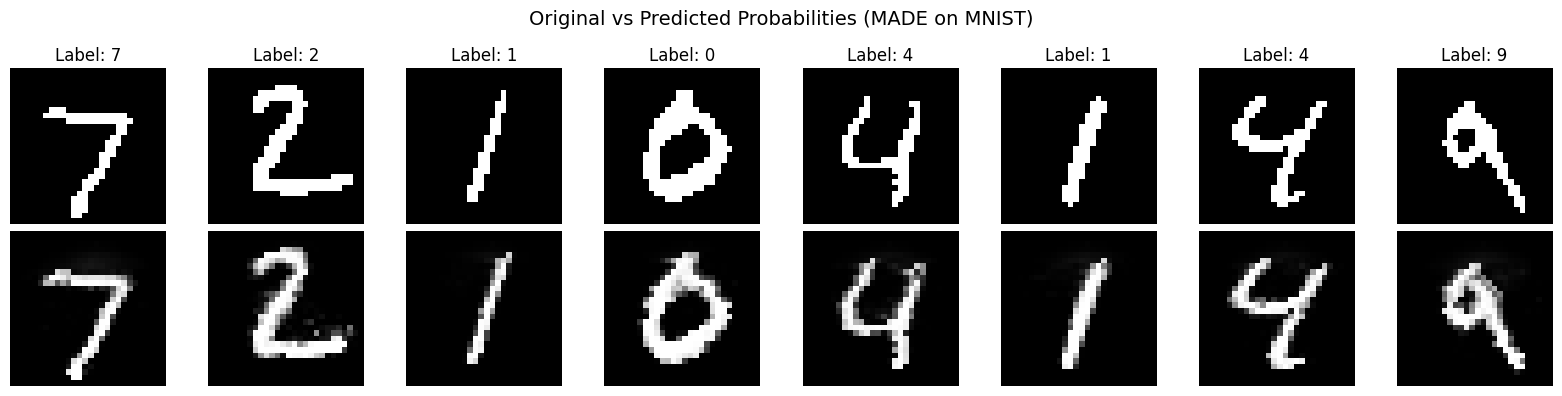

In [137]:
# Take some test images and compare with predictions
model.eval()
n_compare = 8

# Get a batch of test images
test_images = []
test_labels = []
for i in range(n_compare):
    img, label = test_dataset[i]
    test_images.append(img)
    test_labels.append(label)

test_images = torch.stack(test_images).to(device)
test_images_flat = test_images.view(n_compare, -1)

with torch.no_grad():
    logits = model(test_images_flat)
    probs = torch.sigmoid(logits)

# Reshape predictions
probs_images = probs.cpu().numpy().reshape(n_compare, 28, 28)
probs_images = np.clip(probs_images, 0, 1)

# Original images
orig_images = test_images.cpu().numpy().squeeze(1)  # Remove channel dimension

# Plot comparisons
fig, axes = plt.subplots(2, n_compare, figsize=(16, 4))

for i in range(n_compare):
    # Original
    axes[0, i].imshow(orig_images[i], cmap='gray')
    axes[0, i].set_title(f'Label: {test_labels[i]}')
    axes[0, i].axis('off')

    # Predicted probabilities
    axes[1, i].imshow(probs_images[i], cmap='gray')
    axes[1, i].axis('off')

axes[0, 0].set_ylabel('Original', fontsize=12)
axes[1, 0].set_ylabel('Predicted\nProbabilities', fontsize=12)

plt.suptitle('Original vs Predicted Probabilities (MADE on MNIST)', fontsize=14)
plt.tight_layout()
plt.show()

This shows that our model has learnt a good probability distribution

## 13. Conditional Image Completion

Demonstrate the autoregressive property by conditioning on partial images and completing them.

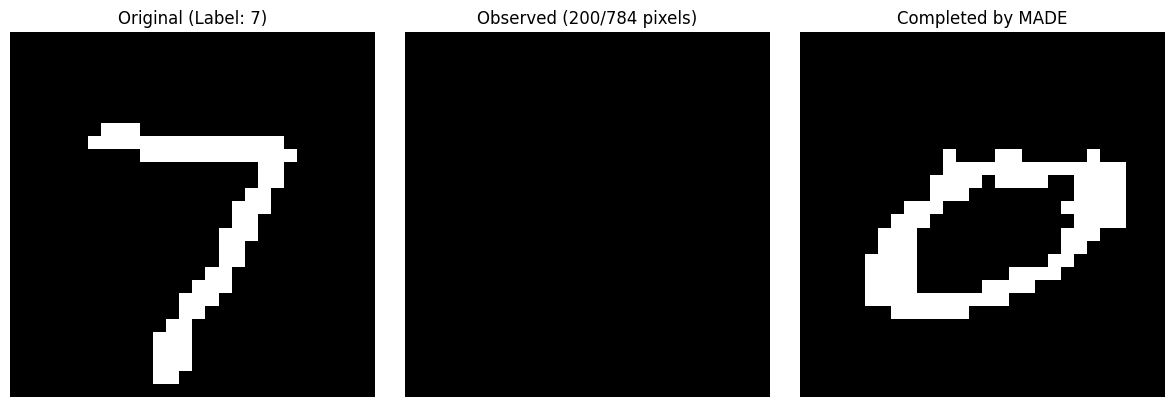

Completed image by sampling 584 pixels conditioned on 200 observed pixels.


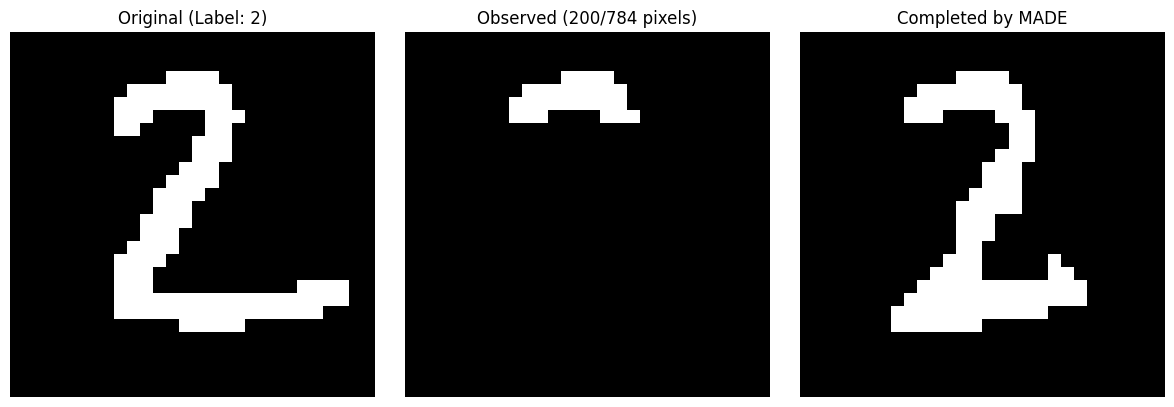

Completed image by sampling 584 pixels conditioned on 200 observed pixels.


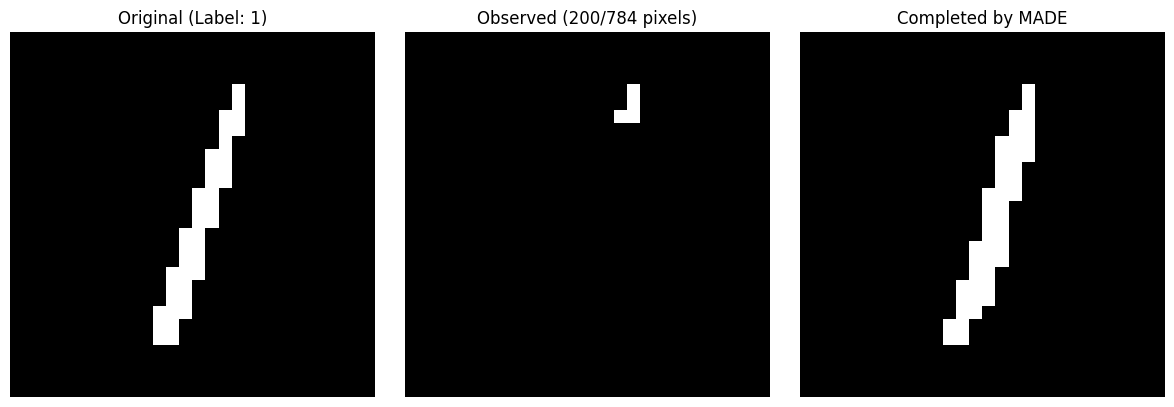

Completed image by sampling 584 pixels conditioned on 200 observed pixels.


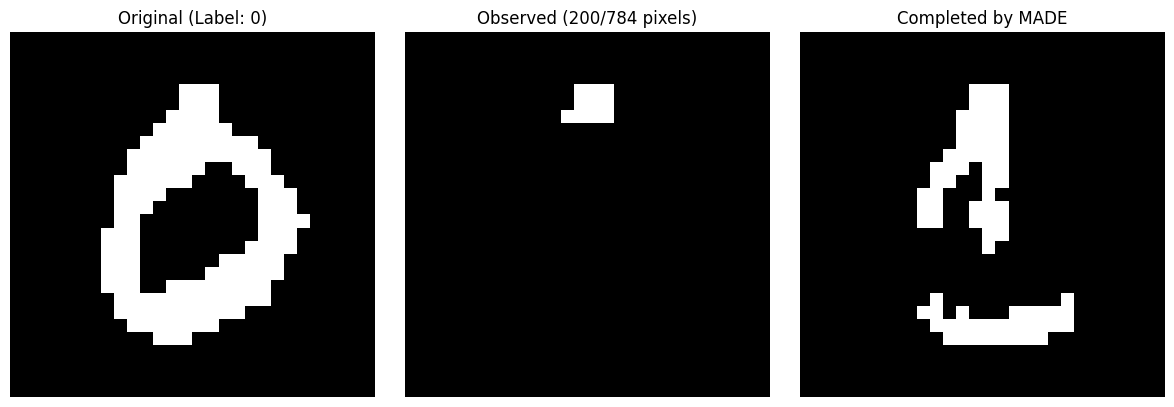

Completed image by sampling 584 pixels conditioned on 200 observed pixels.


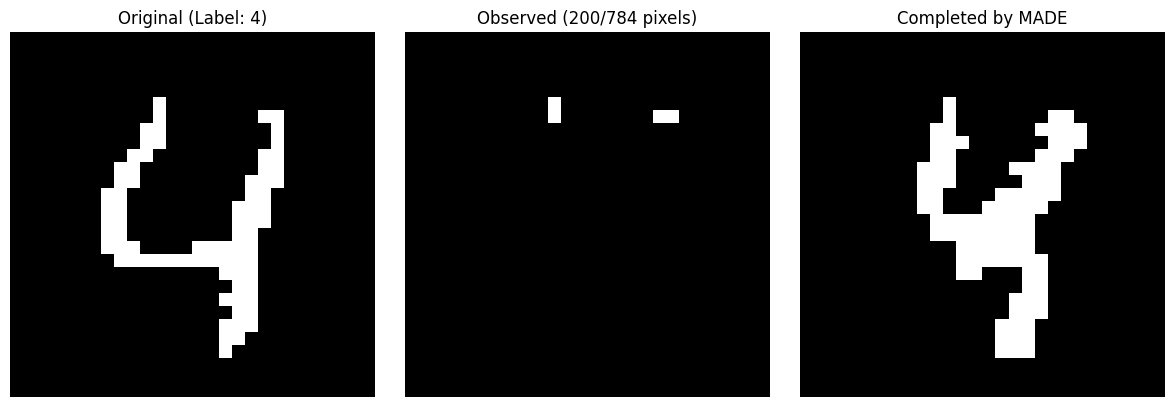

Completed image by sampling 584 pixels conditioned on 200 observed pixels.


In [142]:
# Conditional completion: give the model the left half, generate the right half
model.eval()
for i in range(5) :
  test_img, test_label = test_dataset[i]
  test_img_flat = test_img.view(1, -1).to(device)

  # Create a partial image (first N pixels known, rest to be generated)
  # Each row has 28 pixels, and we have 28 rows
  # Total ordering: pixels in natural order
  # For simplicity, let's condition on the first 50% of dimensions

  partial_img = torch.zeros_like(test_img_flat)
  n_observed = 200  # 392 pixels

  # Copy observed pixels from original image
  partial_img[:, :n_observed] = test_img_flat[:, :n_observed]

  # Sequentially sample the rest
  with torch.no_grad():
      for i in range(n_observed, input_dim):
          logits = model(partial_img)
          probs = torch.sigmoid(logits)

          # Sample pixel i
          partial_img[:, i] = torch.bernoulli(probs[:, i])

  # Reshape for visualization
  original = test_img.squeeze(0).cpu().numpy()  # Remove channel dimension
  completed = partial_img.cpu().numpy().reshape(28, 28)
  completed = np.clip(completed, 0, 1)

  # Create a mask showing what was observed
  mask_flat = np.zeros(28 * 28)
  mask_flat[:n_observed] = 1.0

  # Reshape to (28, 28)
  mask = mask_flat.reshape(28, 28)
  observed = original * mask

  fig, axes = plt.subplots(1, 3, figsize=(12, 4))

  axes[0].imshow(original, cmap='gray')
  axes[0].set_title(f'Original (Label: {test_label})')
  axes[0].axis('off')

  axes[1].imshow(observed, cmap='gray')
  axes[1].set_title(f'Observed ({n_observed}/{input_dim} pixels)')
  axes[1].axis('off')

  axes[2].imshow(completed, cmap='gray')
  axes[2].set_title('Completed by MADE')
  axes[2].axis('off')

  plt.tight_layout()
  plt.show()

  print(f'Completed image by sampling {input_dim - n_observed} pixels conditioned on {n_observed} observed pixels.')

## 14. Calculate FID Score

Fréchet Inception Distance (FID) measures the quality of generated images by comparing their statistics to real images using an Inception network.

In [139]:
from scipy import linalg
from torchvision.models import inception_v3

def get_inception_model():
    """Load pretrained InceptionV3 model for FID calculation."""
    inception = inception_v3(pretrained=True, transform_input=False)
    inception.fc = nn.Identity()  # Remove final classification layer
    inception.eval()
    return inception.to(device)

def preprocess_for_inception(images):
    """
    Preprocess images for Inception network.

    Args:
        images: Tensor of shape (N, 1, 28, 28) in [0, 1] range (grayscale)

    Returns:
        Tensor of shape (N, 3, 299, 299) suitable for InceptionV3
    """
    # Convert grayscale to RGB by repeating channels
    if images.shape[1] == 1:
        images = images.repeat(1, 3, 1, 1)

    # Resize to 299x299 (Inception input size)
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)

    # Normalize to [-1, 1] range (Inception expects this)
    images = (images - 0.5) / 0.5

    return images

def get_inception_features(images, inception_model, batch_size=32):
    """
    Extract features from images using InceptionV3.

    Args:
        images: Tensor of shape (N, 1, H, W) or (N, 3, H, W)
        inception_model: Pretrained InceptionV3 model
        batch_size: Batch size for processing

    Returns:
        Features of shape (N, 2048)
    """
    inception_model.eval()
    features_list = []

    with torch.no_grad():
        for i in range(0, len(images), batch_size):
            batch = images[i:i+batch_size]
            batch = preprocess_for_inception(batch).to(device)

            # Get features
            features = inception_model(batch)
            features_list.append(features.cpu())

    return torch.cat(features_list, dim=0).numpy()

def calculate_fid(real_features, fake_features):
    """
    Calculate Fréchet Inception Distance between real and generated images.

    Args:
        real_features: Features from real images (N, 2048)
        fake_features: Features from generated images (M, 2048)

    Returns:
        FID score (float)
    """
    # Calculate mean and covariance
    mu_real = np.mean(real_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)

    mu_fake = np.mean(fake_features, axis=0)
    sigma_fake = np.cov(fake_features, rowvar=False)

    # Calculate FID
    diff = mu_real - mu_fake

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma_real @ sigma_fake, disp=False)

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff @ diff + np.trace(sigma_real + sigma_fake - 2 * covmean)

    return float(fid)

print("FID calculation functions defined successfully!")
print("Note: FID calculation requires downloading pretrained InceptionV3 (≈100MB)")

FID calculation functions defined successfully!
Note: FID calculation requires downloading pretrained InceptionV3 (≈100MB)


In [140]:
# Load Inception model
print("Loading InceptionV3 model...")
inception_model = get_inception_model()
print("InceptionV3 loaded successfully!")

# Generate samples for FID calculation
print("\nGenerating samples for FID calculation...")
n_fid_samples = 5000  # Use 5000 samples for reliable FID estimate
model.eval()

# Generate in batches to avoid memory issues
batch_size_gen = 500
all_generated_samples = []

for i in range(0, n_fid_samples, batch_size_gen):
    batch_size_current = min(batch_size_gen, n_fid_samples - i)
    samples_batch = model.sample(batch_size_current)
    # Reshape to (N, 1, 28, 28)
    samples_batch = samples_batch.view(batch_size_current, 1, 28, 28)
    all_generated_samples.append(samples_batch)
    print(f"Generated {i + batch_size_current}/{n_fid_samples} samples")

generated_samples = torch.cat(all_generated_samples, dim=0)
print(f"Generated samples shape: {generated_samples.shape}")

# Get real images from test set
print("\nExtracting real images from test set...")
real_images_list = []
for i in range(n_fid_samples):
    img, _ = test_dataset[i % len(test_dataset)]
    real_images_list.append(img)

real_images = torch.stack(real_images_list)
print(f"Real images shape: {real_images.shape}")

# Extract features
print("\nExtracting features from real images...")
real_features = get_inception_features(real_images, inception_model, batch_size=32)
print(f"Real features shape: {real_features.shape}")

print("\nExtracting features from generated images...")
fake_features = get_inception_features(generated_samples, inception_model, batch_size=32)
print(f"Generated features shape: {fake_features.shape}")

# Calculate FID
print("\nCalculating FID score...")
fid_score = calculate_fid(real_features, fake_features)

print(f"\n{'='*50}")
print(f"FID Score: {fid_score:.2f}")
print(f"{'='*50}")
print("\nNote: Lower FID scores indicate better quality generated images.")
print("Typical FID ranges:")
print("  - FID < 50: Good quality")
print("  - FID 50-100: Moderate quality")
print("  - FID > 100: Poor quality")

Loading InceptionV3 model...
InceptionV3 loaded successfully!

Generating samples for FID calculation...
Generated 500/5000 samples
Generated 1000/5000 samples
Generated 1500/5000 samples
Generated 2000/5000 samples
Generated 2500/5000 samples
Generated 3000/5000 samples
Generated 3500/5000 samples
Generated 4000/5000 samples
Generated 4500/5000 samples
Generated 5000/5000 samples
Generated samples shape: torch.Size([5000, 1, 28, 28])

Extracting real images from test set...
Real images shape: torch.Size([5000, 1, 28, 28])

Extracting features from real images...
Real features shape: (5000, 2048)

Extracting features from generated images...
Generated features shape: (5000, 2048)

Calculating FID score...


/tmp/ipython-input-3952767325.py:81: DeprecationWarning: The `disp` argument is deprecated and will be removed in SciPy 1.18.0.
  covmean, _ = linalg.sqrtm(sigma_real @ sigma_fake, disp=False)



FID Score: 13.86

Note: Lower FID scores indicate better quality generated images.
Typical FID ranges:
  - FID < 50: Good quality
  - FID 50-100: Moderate quality
  - FID > 100: Poor quality


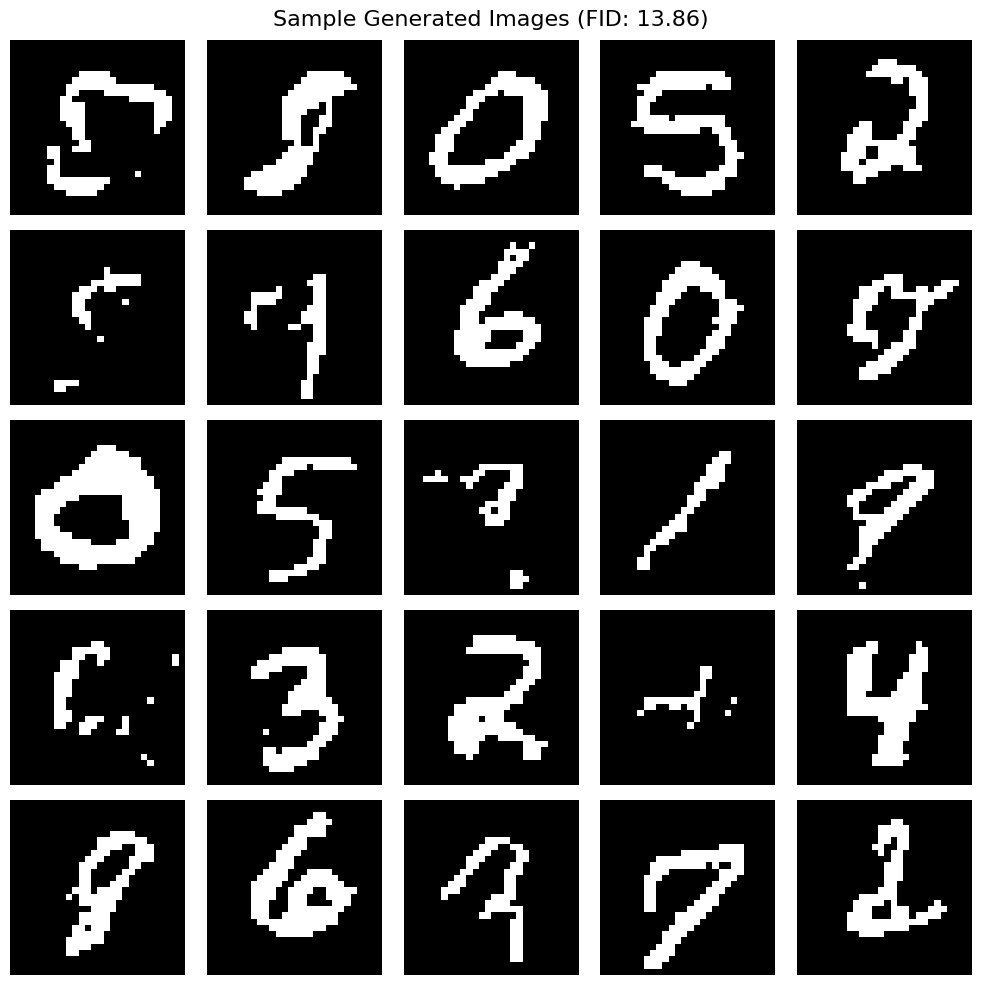

In [141]:
# Visualize some generated samples used for FID
n_vis = 25
vis_samples = generated_samples[:n_vis].cpu().numpy()

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(vis_samples[i].squeeze(), cmap='gray')
    ax.axis('off')
plt.suptitle(f'Sample Generated Images (FID: {fid_score:.2f})', fontsize=16)
plt.tight_layout()
plt.show()

## Summary

This notebook implemented **MADE (Masked Autoencoder for Distribution Estimation)**, a powerful autoregressive generative model. Key highlights:

1. **Masked Connections**: Used masked weight matrices to enforce autoregressive dependencies
2. **Efficient Training**: Unlike traditional autoregressive models, MADE computes all conditional probabilities in a single forward pass
3. **Ancestral Sampling**: Generated new samples by sequentially sampling pixels conditioned on previous ones
4. **Binary MNIST**: Trained on binarized MNIST digits using negative log-likelihood loss

The model learns to capture the joint distribution $p(x_1, x_2, ..., x_{784})$ by factorizing it as:
$$p(x) = \prod_{i=1}^{784} p(x_i | x_{<i})$$

This architecture forms the basis for more advanced models like PixelCNN and autoregressive normalizing flows!